# Option basics

This chapter introduces option payoffs and the [Black-Scholes-Merton model (BSM)](https://www.investopedia.com/terms/b/blackscholes.asp) for pricing **European options**. We will see **call** options and **put** options. Call options give the owner the right, but not the obligation to purchase a stock at a certain price, **X**, or the strike price. 

What makes options and other derivatives interesting? How do we value stocks and bonds? We think about the present value of cash flows. These values, especially for stocks, contain a great deal of uncertainty - we don't know the future! But, options and other derivatives are different. Their value is **based on the value of another security**. It turns out that we can come up with prices for them based on **arbitrage principles**, or the idea that we can "recreate" the derivative from other assets. And, if we know the prices of the other assets, then the derivative **must have a certain price**, or else there's free money to be made.

We'll start with **payoff diagrams**. These tell us what payoff of exercising the option would be, based on the current value of the underlying security, like a stock. When we do this, we'll assume a certain price is paid for the option.

But, what should the price of the option be? How much would you pay, right now, for the right to buy Apple at \$200 a share, three-months from now? That's a three-month Apple call option with a strike of \$200. What should the price be? This is where we can appeal to **arbitrage** and use formulas like **Black-Scholes-Merton** to come up with a price. 

A lot of [crypto and Web3](https://derivs.ftx.us) is related to options, market design, and volatility trading. It's actually kind of strange - the tech community has "reinvented" a lot of traditional finance and is spending a great deal of venture capital funding on creating ways to trade complex derivatives on crypto currencies. Maybe some of the technology will make its way into markets that trade securities based on the "real world" - i.e. assets based on firms, their cash flows, and existing legal structures. At the moment, a lot of it seems like regulatory arbitrage, or creating securities that are outside of current regulatory regimes, like the SEC in the U.S. 

I also introduce two additional, options-related packages. The first, [opstrat](https://github.com/hashabcd/opstrat) let's us do some cool visualizations of calls, puts, and various combinations. The second, [py_vollib](http://vollib.org/documentation/python/1.0.2/index.html), has valuation methods. You can install both using `pip`:

`pip install opstrat`

`pip install py_vollib`


There's a great deal of material in our text book on options. In particular, it focuses on simulation methods to price options, as well as how to create a **class** to define option **objects**. This is an example of **object oriented programming**. 

If you are interested in derivatives, get yourself a cheap copy of [Hull's Options, Futures, and Other Derivatives](https://www.amazon.com/Options-Futures-Other-Derivatives-10th/dp/013447208X). All of this material is on the Level I CFA exam.


Here are some libraries to help us out.

In [64]:
import numpy as np
import scipy.stats as stats
from pylab import cm, mpl, plt
from mpl_toolkits.mplot3d import Axes3D

In [65]:
import opstrat as op
import py_vollib.black_scholes_merton as pyv_bsm
import py_vollib.black_scholes_merton.implied_volatility as pyv_bsm_iv
import py_vollib.black_scholes_merton.greeks.analytical as pyv_bsm_greeks_analytic

## Payoff Diagrams

Let's start with the basic "hockey stick" payoff diagrams that you see in every investments class. We could draw these ourselves using `matplotlib`, but let's use that `opstrat` library instead. After all, one of the reasons for using Python is to get access to the work other people have done for us!

An **option payoff** is defined by: 
- the type of option, call or put
- the strike price ($k$), or the price that you can buy (call) or sell (put) the asset at in the future
- the spot price, or current price of the asset

An **option profit** has one additional factor: 
- the price of the option (C or P), or what it costs to get the right to buy or sell the asset in the future

The **profit functions** for calls and puts are:

- Long Call = max(S - K, 0) - C
- Long Put = max(K - S, 0) - P
- Short Call = -max(S - K, 0) + C
- Short Put = -max(K - S, 0) + P

So, if you are long a call option, you will exercise the option at maturity if S > K. Otherwise, you'll do nothing. You do lose the premium that you paid for the option (C). In that sense, options are **highly levered** securities. If you lose, you lose your entire investment. 

For example, suppose that K = 100 and the stock ends up at 101 at the call options maturity. You will exercise the option, with a payoff of 1 and a profit of 1 - C. But, if the stock ends up at 99, you just lose C. If you buy a stock at 100 and it ends up at 99, you still have 99 worth of stock. 

**European options** can only be exercised on the maturity date of the option. **American options** can be exercised early. The terms don't have anything to do with where the options are traded. 

Finally, there is an important relationship between the call price, the put price, the current stock price, and the borrowing needed to form the portfolio called [put-call parity](https://en.wikipedia.org/wiki/Put–call_parity). 

\begin{align}
C - P = S - Ke^{-rt}
\end{align}

This is an **arbitrage relationship**, as there is free money to be had if it doesn't hold. If you think you observe a situation where it isn't true, it is likely because **transactions costs** (i.e. the costs associated with trading) are preventing market participants from exploiting the difference.

This relationship only holds for options with the same strike and maturity. 



Let's look at the profit diagram for buying a call option with a strike of 125, where you pay 7.5 for the option. We'll look at the profit around the spot price of 125. If the spot price is equal to the strike price, we say that the option is **at-the-money**.

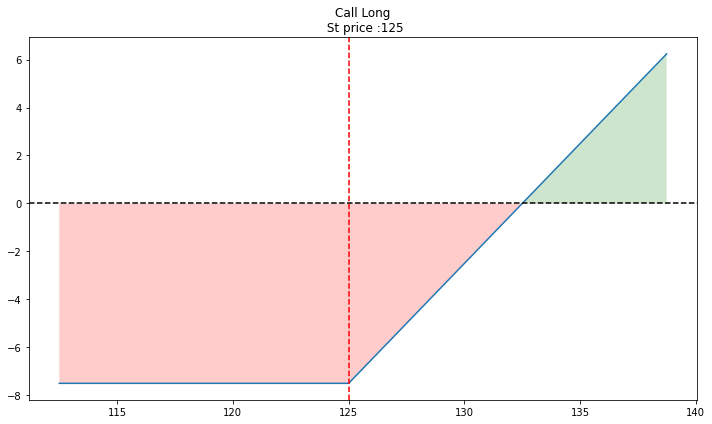

In [66]:

op.single_plotter(spot=125, strike=125, op_type='c', tr_type='b', op_pr=7.5)

See how the blue line starts going up at 125? This is where the strike price is. So, if the stock price is above the strike (S>K), then the option is **in-the-money** and would have a positive **payoff** if exercised. However, the **profit** is negative, because you are paying 7.5 for the option. The blue line crosses the x-axis when you have recovered the 7.5 at 132.5. 

We can then draw all three other diagrams similarly - selling a call, buying a put, and selling a put. 

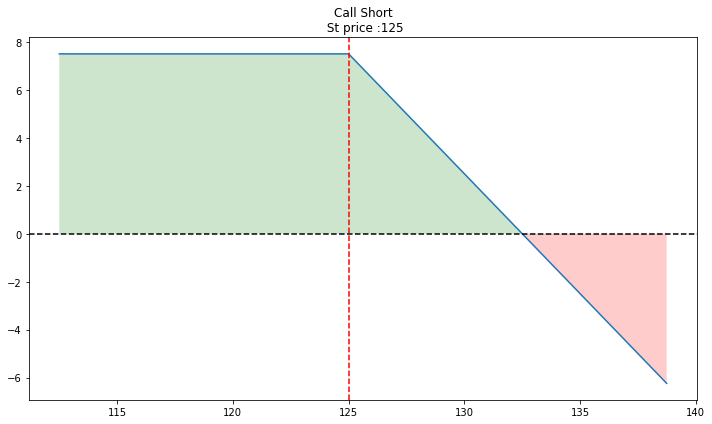

In [67]:
op.single_plotter(spot=125, strike=125, op_type='c', tr_type='s', op_pr=7.5)

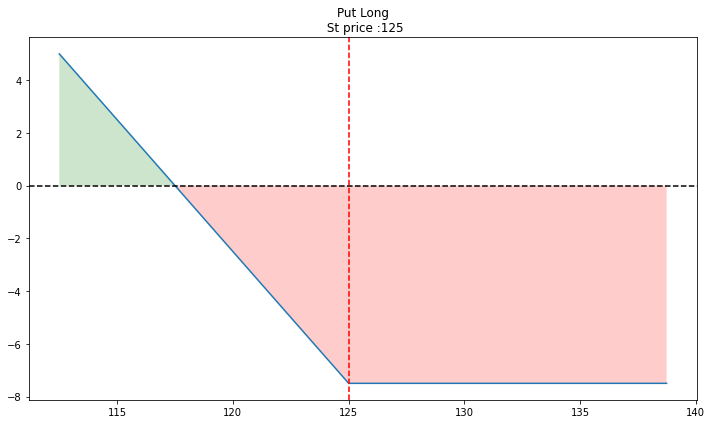

In [68]:
op.single_plotter(spot=125, strike=125, op_type='p', tr_type='b', op_pr=7.5)

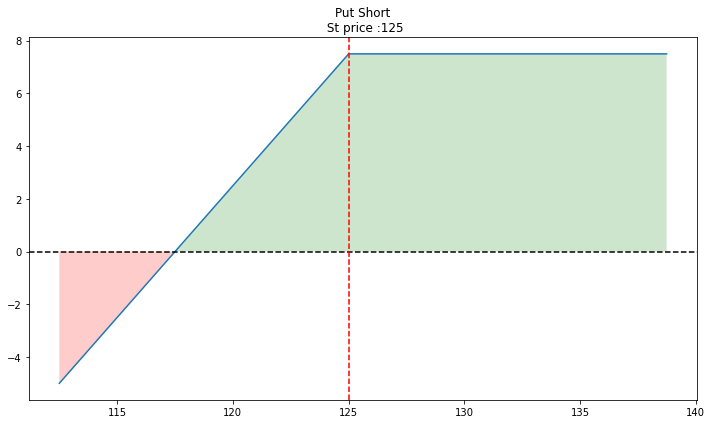

In [69]:
op.single_plotter(spot=125, strike=125, op_type='p', tr_type='s', op_pr=7.5)

The `opstrat` library also lets you **combine** options into various payoffs and strategies. This is one of the features of options that makes them interesting. You can combine them into various payoff structures that let you express complex views about an asset, or hedge complex risks.

For example, the **short strangle** below makes money if the price of the asset doesn't move much. This lets you express a view about the **volatility** of the asset. In fact, this is a **key part** of options and option pricing. Buying and selling options is really like **buying and selling volatility**, as we'll see below when we get to the Black-Scholes-Merton (BSM) formula for finding the price of a European option.

A short strangle consists of:
- selling a slightly out-of-the-money put and 
- selling a slightly out-of-the-money call of the same underlying stock and expiration date. 

With the `opstrat` library, you can define the two options, put them in a list, and then use `.multi_plotter()` to have all of the same profit diagrams on the same graph.

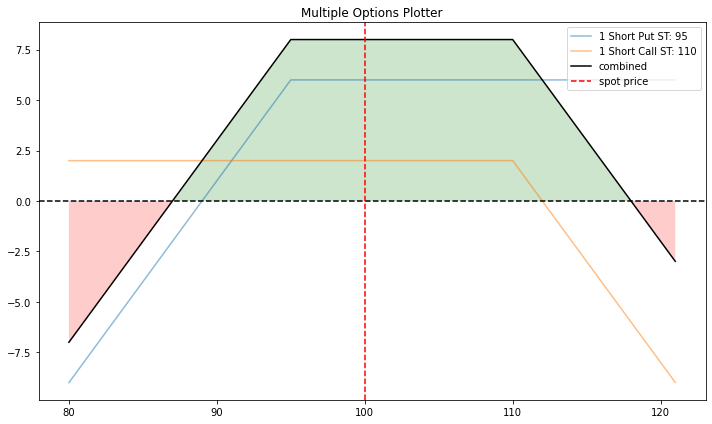

In [70]:
op2 = {'op_type': 'c', 'strike': 110, 'tr_type': 's', 'op_pr': 2}
op1 = {'op_type': 'p', 'strike': 95, 'tr_type': 's', 'op_pr': 6}

op_list = [op1, op2]
op.multi_plotter(spot=100, spot_range=20, op_list=op_list)


## Black-Scholes-Merton

Let's write a **function** that takes the inputs into the BSM model and values a **call option**. You would do something very similar for a **put option**. Again, we are trying to find the **price** that you would pay for the right to buy or sell a stock at a certain price in the future. This price is going to depend on the option contract parameters and, crucially, an assumption about the **volatility** of the asset.

Notice what **does not** appear in the BSM formula - the expected return on the stock! This is the magic. We don't need to have any expectations for Apple's return in order to price their options. 

The BSM formula for a call option price at time 0 (today) is:

\begin{align}
C_0 = S_0N(d_1) - e^{-rT}KN(d_2)
\end{align}

where $C_0$ is the call price, $S_0$ is the stock price today, $K$ is the strike price, $r$ is the risk-free rate, and $T$ is the time-to-maturity. You'll also see $T-t$, where $T$ is the maturity date and $t$ is today's date. We're using $T$ as the number of years (fractional) until the maturity date.

Note that $e^{-rT}$ is just the present value of what it is multiplying when you are doing continuous discounting. In other words, this is like like dividing by $(1+r)^T$, but in continuous time, rather than discrete time. 

One of the **key ideas** with option pricing is the idea of **risk neutral pricing**. This comes from the idea of the arbitrage relationship and allows us to discount payoffs at a known risk-free rate, rather than something more difficult to calculate, like the required return on equity for a stock based on the CAPM.

Now, what is $N()$? This is the **cumulative density function (CDF)** for the standard normal distribution with a mean of 0 and a standard deviation of 1. What is a **CDF**? Put a number into this function. The CDF gives the probability that a random draw from that distribution will be less than or equal to that number (i.e. the area under the curve of the distribution up to that number on the x-axis). So, N(0) = 0.5, since half of the distribution is to the left of the mean.

Finally, what are $d_1$ and $d_2$? They are defined as:

\begin{align}
d_1 = \frac{log\frac{S_0}{K} + (r + \frac{1}{2} \sigma^2)T}{\sigma\sqrt(T)}
\end{align}

\begin{align}
d_2 = d_1 - \sigma\sqrt(T) = \frac{log\frac{S_0}{K} + (r - \frac{1}{2} \sigma^2)T}{\sigma\sqrt(T)}
\end{align}

You see how there's some more $\frac{1}{2}\sigma^2$, logs, $T$, and $\sqrt(T)$, like with our simulations? The underlying math (Brownian motion) is the same. $\sigma^2$ is the variance of the continuously compounded rate of return (log returns) for the asset. Note that we do need to calculate this using data, or some other set of assumptions.

How can we interpret these formulas? Let's re-write the BSM formula:

\begin{align}
C_0 = e^{-rT}(S_0e^{rT}N(d_1) - KN(d_2))
\end{align}


The BSM formula has two pieces. The pieces represent this idea of an **arbitrage** relationship. In other words, we can create an option from other securities. For a call option, we can **replicate the option** by purchasing the stock and then financing that purchase by borrowing the money needed. Like we say with put-call parity, the option is a combination of the stock and borrowing. 

But how much stock do we need to recreate an option? After some math, we can find that this $N(d_1)$ is always between 0 and 1 and is the number of shares that we need to purchase. If the call option is at expiration and **in-the-money**, then one option is just one share, so $N(d_1)$ = 1, the max possible value. If the call option expires **out-of-the-money**, then it is worth $N(d_1)$ = 0, or no shares. 

$S_0e^{rT}N(d_1)$ represents the future value of the underlying asset conditional on the end stock value S_T being greater than the strike price K (S > K). The second term in the brackets, $KN(d_2)$, is the value of the payment K (also the strike price) times the probability that the strike price will be paid, $N(d_2)$. So, $N(d_1)$ represents the number of shares of stock you'd need to own to replicate the option. $N(d_2)$ is the probability that the option ends up **in-the-money**. 

In [71]:
def bsm_call_value(S, K, T, r, sigma):
    
    ''' Valuation of European call option in BSM model.
    Analytical formula.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    value: float
    present value of the European call option
    '''
    
    from math import log, sqrt, exp
    from scipy import stats
    
    S = float(S) # This is the current stock price. float() just makes sure that it is that type of number, and not in integer.
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # stats.norm.cdf --> cumulative distribution function
    # for normal distribution
    value = (S * stats.norm.cdf(d1, 0.0, 1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return value


Remember, **indentation matters**! And you need that `return value` at the end, or else the function won't give you back anything when you use it.

In [72]:
bsm_call_value(100, 120, 1, 0.03, 0.25)

4.463301711346105

So, the BSM price for this call option is 4.46. 

Options have values associated with them called [greeks](https://en.wikipedia.org/wiki/Black–Scholes_model#The_Options_Greeks). These are values like **vega** and **delta**. There are many others, each with their own formula. The individual "Greek" formulas come from BSM formula, where you take **partial derivatives** with respect to the thing you're interest in. 

For example, [vega](https://www.investopedia.com/terms/v/vega.asp) is how the option price, in this case a call option, changes with respect to the change in volatility ($\frac{dC}{d\sigma}$).

Fun fact: Vega isn't even a Greek letter.

Notice that we need the **probability density function (PDF)** in the vega function below. The PDF tells us the probability density of a particular value from a given distribution. It is also the first derivative of the CDF.

Another fun fact: Probability densities aren't quite probabilities. We are dealing with continuous functions. The probability that any draw from a normal distribution has an particular value is.... zero! Why? What is the probability of pulling the number 0.562840274231... from the standard normal distribution? The decimal places go on forever. You'll never get that exact number! In fact, there are more [numbers between 0 and 1](https://philosophicaltreasures.com/countable-and-uncountable-infinities/) then there are all of the integers that you can count. Instead, we are looking at the probability in an **infinitesimal window** around some value. You can [read more here](https://en.wikipedia.org/wiki/Probability_density_function). 

Anyway, things work out fine in the math the way we are using it. We are again using the standard normal distribution.

In [73]:
def bsm_vega(S, K, T, r, sigma):
    ''' Vega of European option in BSM model.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    strike price
    T: float
    maturity date (in year fractions)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    Returns
    =======
    vega: float
    partial derivative of BSM formula with respect
    to sigma, i.e. vega
    '''
    from math import log, sqrt
    from scipy import stats
    S0 = float(S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    vega = S * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [74]:
bsm_vega(100, 120, 1, 0.03, 0.25)

35.479855257007806

How do you interpret this number? If the volatility of the underlying asset goes up by 1%, then the price of the option should increase by 0.35. 

Here's a function to find **delta**. Again, delta tells us the **moneyness** of the option. How much is the call option actually like the stock? 

In [75]:
def bsm_delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = stats.norm.cdf(d1)
    return delta 

In [76]:
bsm_delta_call(100, 120, 1, 0.03, 0.25)

0.3140913745355983

How do you interpret this number? You would need to own 0.31 shares of the stock in order to replicate this call option. This call is **out-of-the-money**, since S < K. As S goes up, the delta of the option will go up, since the option starts to look more and more like just owning the stock.

We can also solve for something called **implied volatility**. Volatility, or $\sigma^2$, is an input into the BSM model. But, what if you take the observed market price of the option as a given. You can then "solve" for the volatility that sets the BSM price equal to the observed market price.

Here's a function that does that. I'll give it the call price from above and we can see if it finds the volatility we assumed (0.25, or 25%).

In [77]:

def bsm_call_imp_vol(S, K, T, r, C, sigma_est, tol=0.0001, max_iterations=100):
    '''

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''


    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = sigma_est
    
    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = bsm_call_value(S, K, T, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print(f'found on {i}th iteration')
            print(f'difference is equal to {diff}')
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / bsm_vega(S, K, T, r, sigma)

    return sigma

In [78]:
C = 4.463301711346105
bsm_call_imp_vol(100, 120, 1, 0.03, C, 0.20)

found on 3th iteration
difference is equal to 9.009966106532374e-10


0.2500000000253945

And it does! It's beyond the scope of what we're doing, but this code is using [numerical methods](https://www.codearmo.com/blog/implied-volatility-european-call-python) to search for and find the "correct" volatility. Specifically, it is using the [Newton-Rapshon method](https://en.wikipedia.org/wiki/Newton%27s_method). Yeah, that Newton! He didn't come up with option pricing formulas, but it is fitting that we use approaches he developed, since he [loved to speculate and lost a fortune trading stocks](https://www.smithsonianmag.com/smart-news/market-crash-cost-newton-fortune-180961655/).

## py_vollib library

The [py_vollib](http://vollib.org/documentation/python/1.0.2/index.html) library has a lot of useful functions for option pricing. 

For example, we can find the BSM price and implied volatility for our call option. Note that there is another parameter, $q$, which is the annualized continuous dividend rate. We've been ignoring dividends. 

In [ ]:
S = 100
K = 120
sigma = .25
r = .03
flag = 'c'
t = 1
q = 0

price = pyv_bsm.black_scholes_merton(flag, S, K, t, r, sigma, q)
print(price)

iv = pyv_bsm_iv.implied_volatility(price, S, K, t, r, q, flag)
print(iv)

delta = pyv_bsm_greeks_analytic.delta(flag, S, K, t, r, sigma, q)
print(delta)


4.463301711346105
0.25
0.3140913745355983


That worked too!